In [1]:
import pandas as pd
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
dataset = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

# Read the dataset into a Pandas DataFrame
TITANIC = pd.read_csv(dataset)

In [3]:
import sys
sys.path.append('..')
from xDL.models.NATT import NATT

In [4]:
model = NATT(
    "survived ~  -1 + MLP(fare) +  MLP(age) + Transformer(sex):Transformer(deck)", 
    data=TITANIC, 
    feature_dropout=0.0001,
    binning_task="regression"
    )

--- Preprocessing ---


5it [00:01,  4.11it/s]
4it [00:00, 542.29it/s]


In [5]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy()},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR'), tf.keras.metrics.AUC(name="auc")]},
    )

history = model.fit(
    model.training_dataset, 
    epochs=20, 
    validation_data=model.validation_dataset,
    verbose=1
)

Epoch 1/20
------------- Network architecture --------------
Transformer -> (ListWrapper(['sex', 'deck']), dims=32, depth=4, heads=8) -> MLP(input_dim=64) -> output dimension=1
fare -> MLP(feature=fare, n_params=12736) -> output dimension=1
age -> MLP(feature=age, n_params=12736) -> output dimension=1
1/1 [==============================] - 18s 18s/step - loss: 3.8567 - output_loss: 3.8567 - output_PR AUC: 0.4276 - output_auc: 0.5266 - val_loss: 1.6322 - val_output_loss: 1.6322 - val_output_PR AUC: 0.5221 - val_output_auc: 0.6636
Epoch 2/20
1/1 [==============================] - 0s 128ms/step - loss: 3.4516 - output_loss: 3.4516 - output_PR AUC: 0.4045 - output_auc: 0.5073 - val_loss: 0.9541 - val_output_loss: 0.9541 - val_output_PR AUC: 0.4372 - val_output_auc: 0.5906
Epoch 3/20
1/1 [==============================] - 0s 122ms/step - loss: 3.2111 - output_loss: 3.2111 - output_PR AUC: 0.4350 - output_auc: 0.5074 - val_loss: 0.9699 - val_output_loss: 0.9699 - val_output_PR AUC: 0.3655 - 

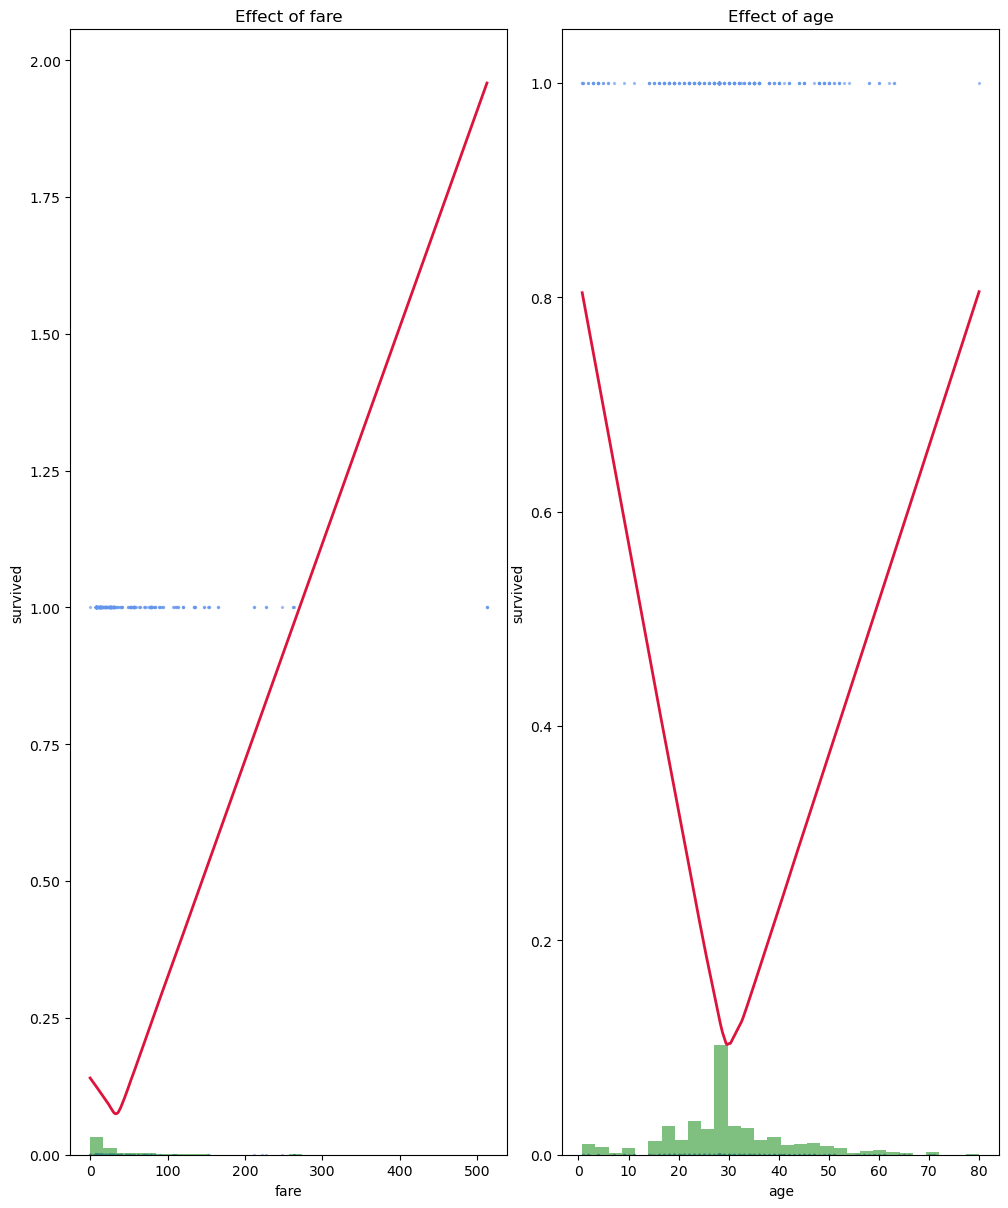

In [6]:
model.plot()

--- Preprocessing ---


0it [00:00, ?it/s]

5it [00:00,  8.95it/s]


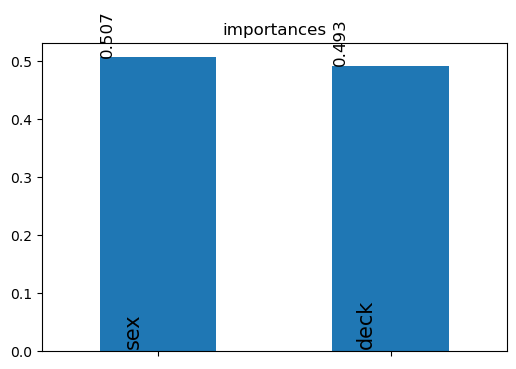

In [7]:
model.plot_importances()

In [16]:
model.plot_all_effects(port=8051)

In [9]:
model.plot_single_effects(port=8052)

--- Preprocessing ---


0it [00:00, ?it/s]

5it [00:00,  8.85it/s]


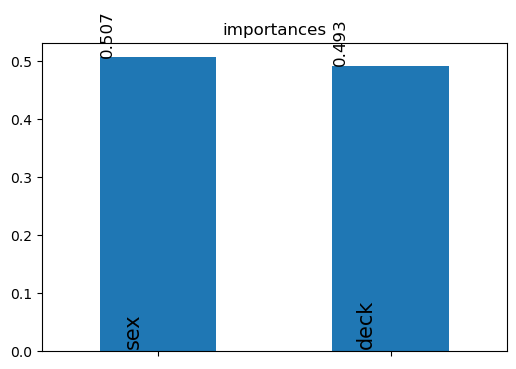

In [10]:
model.plot_importances()

--- Preprocessing ---


0it [00:00, ?it/s]

5it [00:00,  8.56it/s]


<Figure size 1200x400 with 0 Axes>

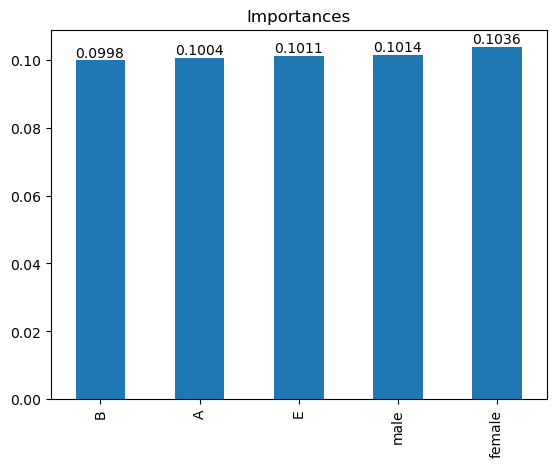

In [11]:
model.plot_categorical_importances()

--- Preprocessing ---


0it [00:00, ?it/s]

5it [00:00,  9.17it/s]
c:\Users\anton\anaconda3\envs\xDL_venv\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



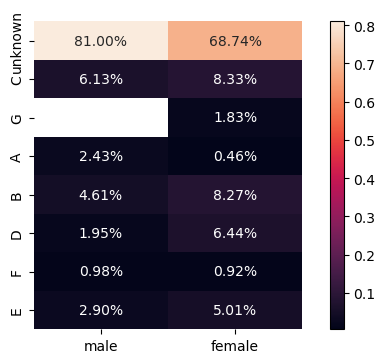

In [12]:
model.plot_heatmap_importances("sex", "deck")

# test continuous feature interactions

In [13]:
model = NATT(
    "survived ~  -1 + MLP(fare):MLP(age) + Transformer(sex):Transformer(deck):Transformer(embark_town)",
    data=TITANIC, 
    feature_dropout=0.0001)

--- Preprocessing ---


6it [00:00,  9.40it/s]
5it [00:00, ?it/s]


In [14]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None, "att_weights": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR'), "accuracy"], "importances": None, "att_weights": None},)

history = model.fit(
    model.training_dataset, 
    epochs=30, 
    validation_data=model.validation_dataset,
    verbose=1
)

Epoch 1/30


------------- Network architecture --------------
Transformer -> (ListWrapper(['sex', 'deck', 'embark_town']), dims=32, depth=4, heads=8) -> MLP(input_dim=96) -> output dimension=1
fare_._age -> MLP(feature=fare_._age, n_params=12864) -> output dimension=1
1/1 [==============================] - 9s 9s/step - loss: 5.4306 - output_loss: 5.4306 - output_PR AUC: 0.3570 - output_accuracy: 0.6355 - val_loss: 6.1700 - val_output_loss: 6.1700 - val_output_PR AUC: 0.4000 - val_output_accuracy: 0.6000
Epoch 2/30
1/1 [==============================] - 0s 156ms/step - loss: 5.9313 - output_loss: 5.9313 - output_PR AUC: 0.3980 - output_accuracy: 0.5996 - val_loss: 7.4040 - val_output_loss: 7.4040 - val_output_PR AUC: 0.4800 - val_output_accuracy: 0.5200
Epoch 3/30
1/1 [==============================] - 0s 154ms/step - loss: 5.6080 - output_loss: 5.6080 - output_PR AUC: 0.3695 - output_accuracy: 0.6116 - val_loss: 5.0548 - val_output_loss: 5.0548 - val_output_PR AUC: 0.3748 - val_output_accuracy: 0.